In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10  # https://www.cs.toronto.edu/~kriz/cifar.html

In [3]:
import torchvision.transforms as T
dataset_train = CIFAR10('../cifar10', train=True, transform=T.ToTensor(), download=True)

100%|██████████| 170498071/170498071 [00:10<00:00, 16075557.50it/s]


Extracting ../cifar10/cifar-10-python.tar.gz to ../cifar10


In [6]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [7]:
#!g1.1
means = (dataset_train.data / 255).mean(axis=(0, 1, 2))
stds = (dataset_train.data / 255).std(axis=(0, 1, 2))

train_transforms = T.Compose(
    [
        T.RandomResizedCrop(size=32, scale=(0.8, 1.1)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomAdjustSharpness(sharpness_factor=2),
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

test_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

train_dataset = CIFAR10('../cifar10', train=True, transform=train_transforms)
valid_dataset = CIFAR10('../cifar10', train=False, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
def create_advanced_skip_connection_conv_cifar():
    model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),  # 32 x 32 x 64
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),  # 32 x 32 x 64
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.MaxPool2d(2),  # 16 x 16 x 64
    nn.Dropout2d(p=0.2),

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # 16 x 16 x 128
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),  # 16 x 16 x 128
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.MaxPool2d(2),  # 8 x 8 x 128
    nn.Dropout2d(p=0.2),

    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),  # 8 x 8 x 256
    nn.BatchNorm2d(256),
    nn.ReLU(),

    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),  # 8 x 8 x 256
    nn.BatchNorm2d(256),
    nn.ReLU(),

    nn.MaxPool2d(2),  # 4 x 4 x 256
    nn.Dropout2d(p=0.2),

    nn.Flatten(),

    nn.Linear(4 * 4 * 256, 512),
    nn.BatchNorm1d(512),
    nn.Dropout(p=0.3),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
    return model

In [9]:
#!g1.1
from tqdm import tqdm


def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        
        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [10]:
#!g1.1
@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [11]:
#!g1.1
from IPython.display import clear_output

def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [12]:
#!g1.1
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

In [13]:
#!g1.1
import torch.nn as nn
from torch.optim import Adam

In [14]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

loss_fn = nn.CrossEntropyLoss()

cuda:0
Tesla P100-PCIE-16GB


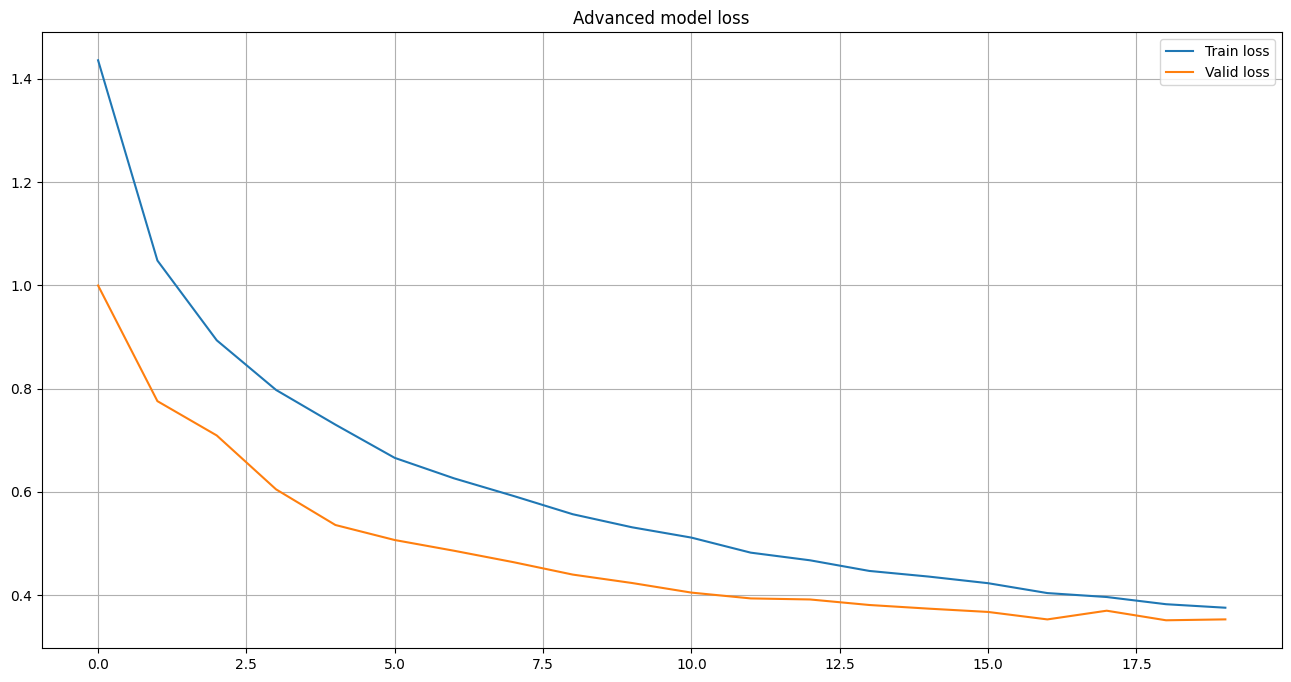

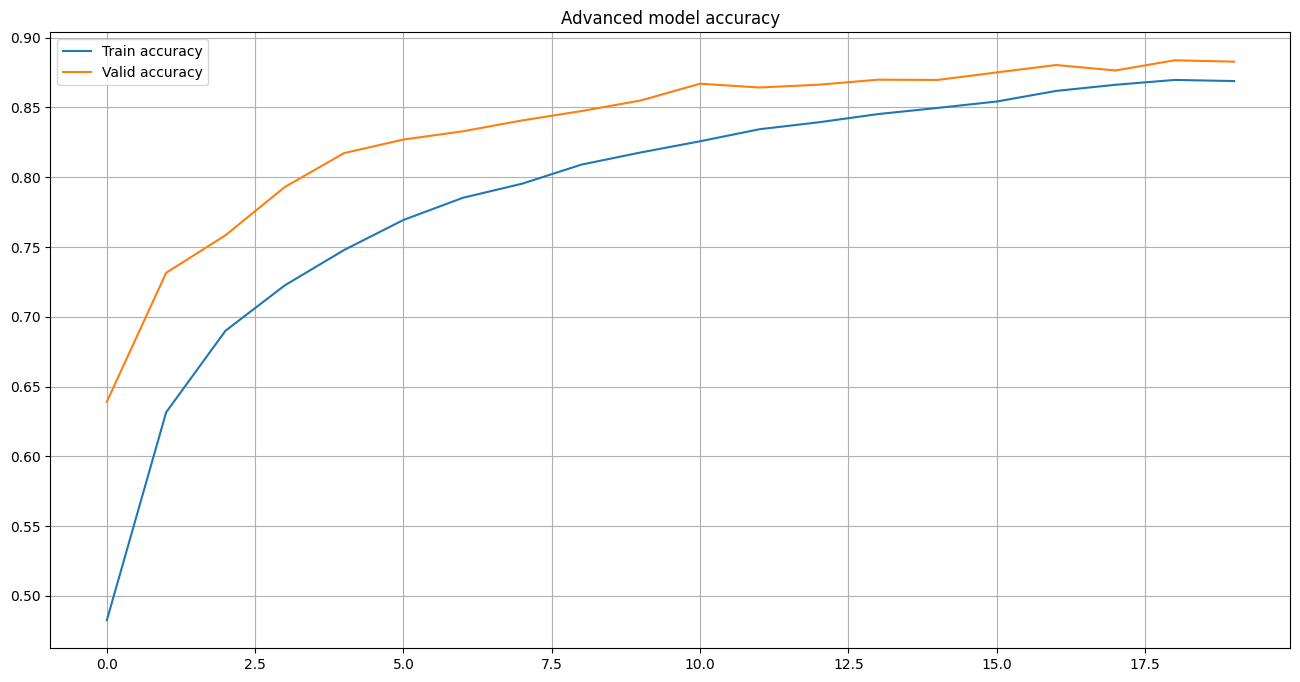

In [15]:
#!g1.1
model = create_advanced_skip_connection_conv_cifar()
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

whole_train_valid_cycle(model, 20, 'Advanced model')